## Data Loading

In [1]:
import polars as pl

df_dsa = pl.read_ipc("data/Beer_Analyzer_Data_full.feather")
df_nir = pl.read_ipc("data/Fermentation_NIR_absorbance_full.feather")

df_dsa = df_dsa.with_columns(
    pl.col('BatchName').cast(pl.Utf8)
)

Number of spectra and samples from the individual batches

In [3]:
counts_spectra = df_nir["BatchName"].value_counts().sort("BatchName")
counts_samples = df_dsa["BatchName"].value_counts().sort("BatchName")

counts = counts_spectra.join(counts_samples, on="BatchName")
counts = counts.rename({"count": "n_spectra", "count_right": "n_samples"})

counts

BatchName,n_spectra,n_samples
str,u32,u32
"""01_Zwickelbier""",7084,14
"""02_Zwickelbier""",6597,15
"""03_Zwickelbier""",10659,16
"""04_Wiener_Lager""",6128,14
"""05_European_Red_Lager""",6473,16
"""06_Uni_Pils""",6371,16


## Outlier detection

C:\Users\hofma\AppData\Local\Temp\ipykernel_32848\1231547572.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


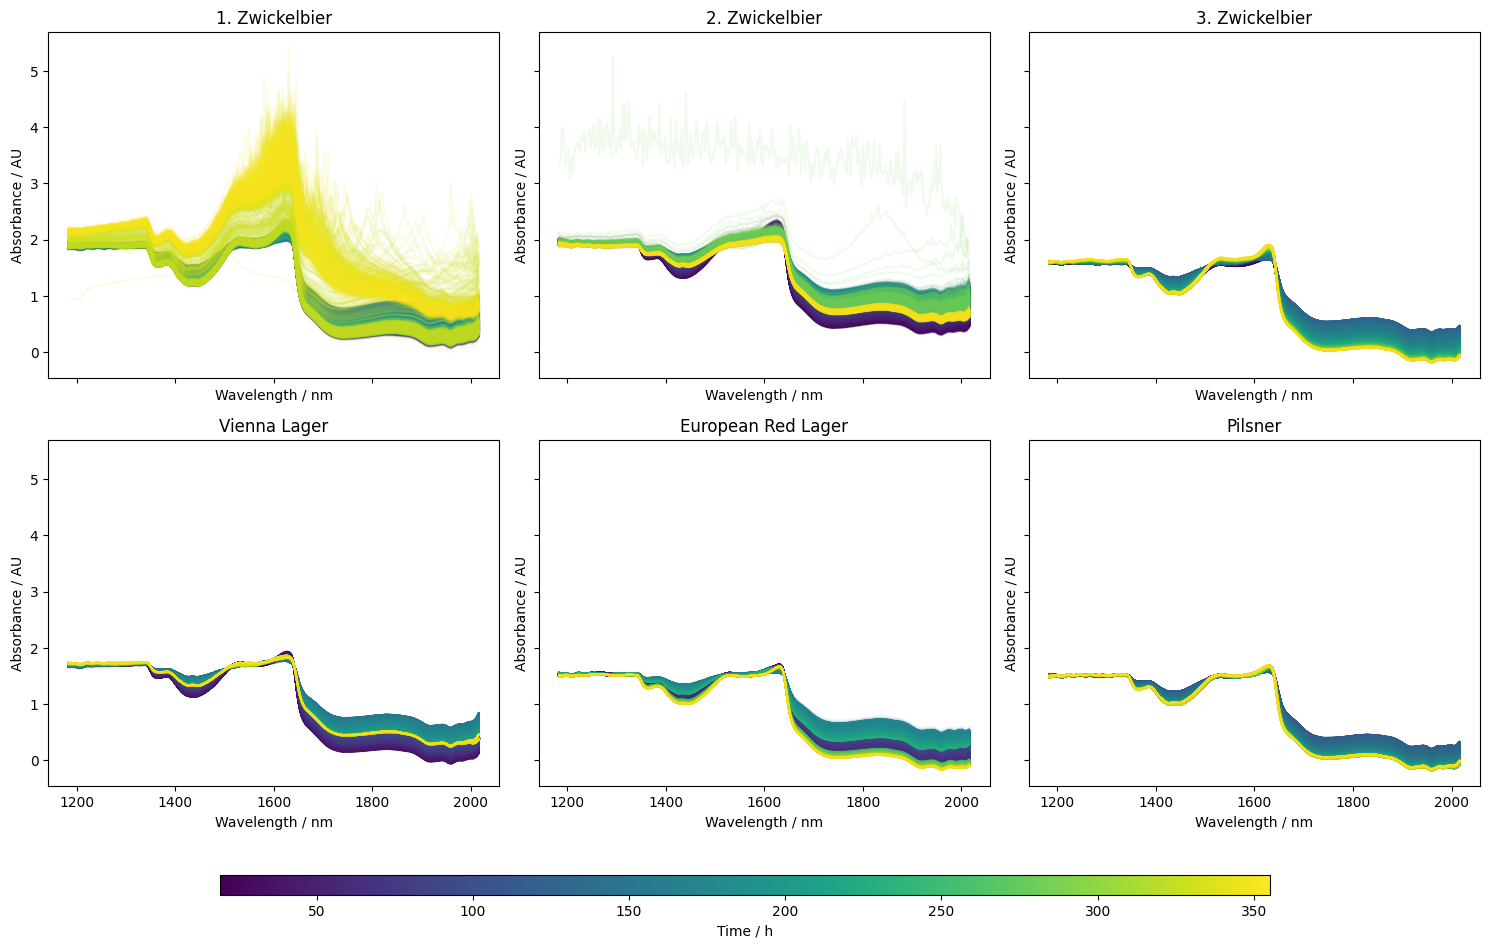

In [49]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from chemotools.feature_selection import RangeCut
import matplotlib.cm as cm
import numpy as np

batch_names = ["1. Zwickelbier", "2. Zwickelbier", "3. Zwickelbier", "Vienna Lager", "European Red Lager", "Pilsner"]

batches = df_nir["BatchName"].unique().sort().to_list()
n_batches = len(batches)
n_cols = 3
n_rows = int(np.ceil(n_batches / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
rcbi = RangeCut(30, -30)
# Create a colormap for time values
cmap = cm.viridis  # You can choose any colormap you prefer: plasma, inferno, magma, coolwarm, etc.
wavelengths = np.linspace(1100, 2100, 359)[30:-30]  # Example

for i, batch in enumerate(batches):
    ax = axes[i // n_cols, i % n_cols]
    batch_data = df_nir.filter(pl.col("BatchName") == batch)
    spectra = batch_data.select(pl.col("^WL.*$")).to_numpy()
    time_values = batch_data.select(pl.col("CumulativeTime")).to_numpy().flatten()
    
    spectra = rcbi.fit_transform(spectra)
    
    # Normalize time values for colormap
    norm = Normalize(vmin=time_values.min(), vmax=time_values.max())
    
    # Plot each spectrum with color based on time
    for j, spectrum in enumerate(spectra):
        color = cmap(norm(time_values[j]))
        ax.plot(wavelengths, spectrum, color=color, alpha=0.1)
    
    ax.set_title(batch_names[i])
    ax.set_xlabel("Wavelength / nm")
    ax.set_ylabel("Absorbance / AU")

# Add a horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Time / h')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.savefig("spectra_with_outlier.jpg", dpi=600, bbox_inches='tight')  # Adjust layout to make space for colorbar
plt.show()

In [ ]:
from NIRBeer.outlier_detection import detect_outliers
from chemotools.feature_selection import RangeCut

rcbi = RangeCut(30, -30)

result = detect_outliers(df_nir, alpha=0.05, var_threshold=0.95, range_cut=rcbi)

print("Removed", df_nir.shape[0] - result.num_inliers, "outliers")

Removed 1250 outliers


In [480]:
result.df_inliers.shape

(42062, 362)

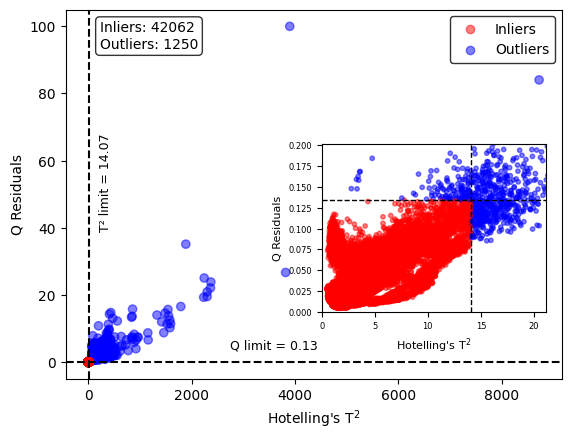

In [477]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
scatter = plt.scatter(result.t2, result.q, c=result.inliers_mask, cmap="bwr", alpha=0.5)   
plt.axvline(result.t2_limit, color="black", ls="--")
plt.axhline(result.q_limit, color="black", ls="--")
plt.xlabel("Hotelling's T$^2$")
plt.ylabel("Q Residuals") 

# Add text labels for the limit lines on the main plot
plt.text(200, plt.ylim()[1] * 0.65, f'T² limit = {result.t2_limit:.2f}', 
         ha='left', va='top', rotation=90, fontsize=9, backgroundcolor='white')
plt.text(plt.xlim()[1] * 0.3, 3, f'Q limit = {result.q_limit:.2f}', 
         ha='left', va='bottom', rotation=0, fontsize=9, backgroundcolor='white')

# Calculate inliers and outliers counts
inliers_count = np.sum(result.inliers_mask)
outliers_count = np.sum(~result.inliers_mask)
total_count = len(result.inliers_mask)

# Add textbox with counts in upper right corner
textstr = f'Inliers: {inliers_count}\nOutliers: {outliers_count}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(225, plt.ylim()[1] * 0.9675, textstr, fontsize=10,
         va='top', ha='left', bbox=props)

# Add legend with scatter markers
plt.scatter([], [], c='red', alpha=0.5, label='Inliers')
plt.scatter([], [], c='blue', alpha=0.5, label='Outliers')
plt.legend(edgecolor='black', fancybox=True, framealpha=0.8)  # Moved legend to lower left to avoid overlap

# Create inset axes in the right bottom corner
inset_ax = plt.axes([0.525, 0.25, 0.35, 0.35])  # [left, bottom, width, height]

# Plot the same data on the inset axes (without text labels)
inset_ax.scatter(result.t2, result.q, c=result.inliers_mask, cmap="bwr", alpha=0.5, s=10)
inset_ax.axvline(result.t2_limit, color="black", ls="--", linewidth=1)
inset_ax.axhline(result.q_limit, color="black", ls="--", linewidth=1)

# Set the limits for the zoomed-in region
inset_ax.set_xlim(0, result.t2_limit * 1.5)
inset_ax.set_ylim(0, result.q_limit * 1.5)

# Add labels to inset (optional)
inset_ax.set_xlabel("Hotelling's T$^2$", fontsize=8)
inset_ax.set_ylabel("Q Residuals", fontsize=8)
inset_ax.tick_params(labelsize=6)
plt.savefig("outlier_detection.jpg", dpi=600, bbox_inches='tight')
plt.show()

C:\Users\hofma\AppData\Local\Temp\ipykernel_28072\3103427698.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


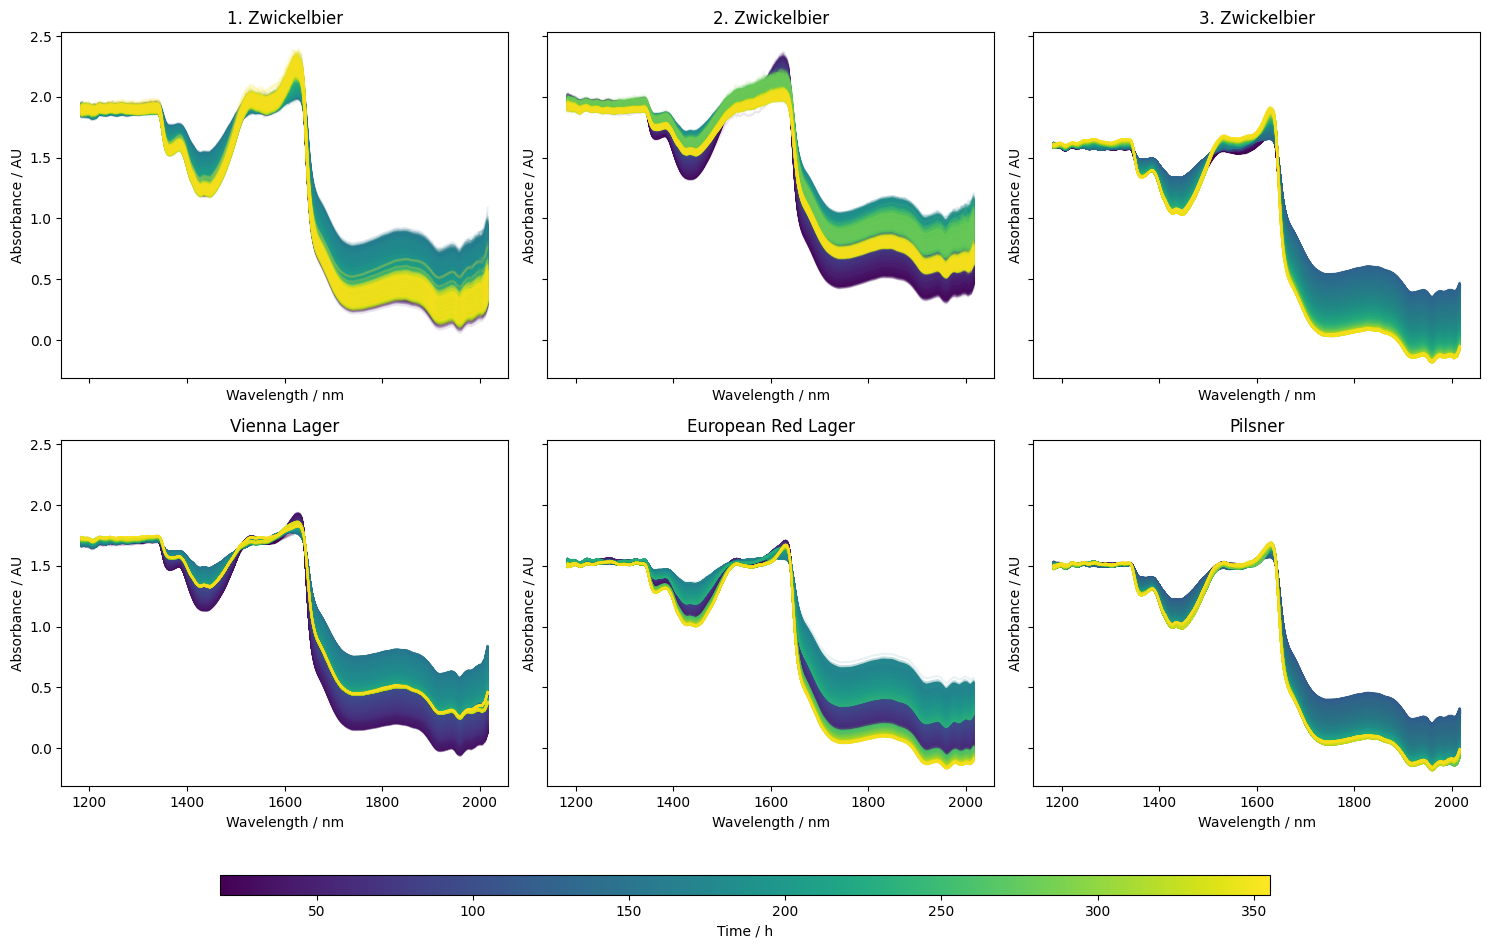

In [478]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np

df_nir_clean = result.df_inliers

batch_names = ["1. Zwickelbier", "2. Zwickelbier", "3. Zwickelbier", "Vienna Lager", "European Red Lager", "Pilsner"]

batches = df_nir_clean["BatchName"].unique().sort().to_list()
n_batches = len(batches)
n_cols = 3
n_rows = int(np.ceil(n_batches / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
rcbi = RangeCut(30, -30)
# Create a colormap for time values
cmap = cm.viridis  # You can choose any colormap you prefer: plasma, inferno, magma, coolwarm, etc.
wavelengths = np.linspace(1100, 2100, 359)[30:-30]  # Example

for i, batch in enumerate(batches):
    ax = axes[i // n_cols, i % n_cols]
    batch_data = df_nir_clean.filter(pl.col("BatchName") == batch)
    spectra = batch_data.select(pl.col("^WL.*$")).to_numpy()
    time_values = batch_data.select(pl.col("CumulativeTime")).to_numpy().flatten()
    
    spectra = rcbi.fit_transform(spectra)
    
    # Normalize time values for colormap
    norm = Normalize(vmin=time_values.min(), vmax=time_values.max())
    
    # Plot each spectrum with color based on time
    for j, spectrum in enumerate(spectra):
        color = cmap(norm(time_values[j]))
        ax.plot(wavelengths, spectrum, color=color, alpha=0.1)
    
    ax.set_title(batch_names[i])
    ax.set_xlabel("Wavelength / nm")
    ax.set_ylabel("Absorbance / AU")

# Add a horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Time / h')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.savefig("spectra_outlier_removed.jpg", dpi=600, bbox_inches='tight')  # Adjust layout to make space for colorbar
plt.show()

## Data sampling

In [476]:
from NIRBeer.interpolation import interpolate_targets_to_spectra

df_interpolate = interpolate_targets_to_spectra(result.df_inliers, df_dsa)

In [ ]:
import polars as pl
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- User-defined parameters from the Julia code ---
min_time = 3 #3
max_time = 16
k_rate = 50
exponent = 3 / 2


# --- Python Implementation of the Sampling Algorithm ---

def adaptive_time_sampler(
    df_group: pl.DataFrame,
    min_dt: float,
    max_dt: float,
    rate_k: float,
    exp_val: float
) -> pl.DataFrame:
    """
    Applies the adaptive sampling logic to a single batch (a DataFrame group).

    This function is designed to be used with Polars' group_by().apply().
    """
    last_time = -float('inf')
    selected_rows = []

    # iter_rows is efficient for this kind of stateful iteration
    for row in df_group.iter_rows(named=True):
        t = row['CumulativeTime']
        dE = row['derivative_magnitude']

        # Calculate the desired local time step (dt_local)
        # The core of the algorithm: dt is small when dE is large, and large when dE is small.
        dt_local = max_dt * np.exp(-rate_k * dE) ** exp_val

        # Enforce the minimum time step
        dt_local = max(dt_local, min_dt)

        if t >= last_time + dt_local:
            selected_rows.append(row)
            last_time = t

    if not selected_rows:
        return df_group.clear() # Return empty frame if no rows selected

    # Return a new DataFrame constructed from the selected rows
    return pl.from_dicts(selected_rows, schema=df_group.schema).sort(["BatchName", "CumulativeTime"])

# --- Applying the function to each batch in the DataFrame ---
selected_df = df_interpolate.group_by("BatchName", maintain_order=True).map_groups(
    lambda df_group: adaptive_time_sampler(
        df_group,
        min_dt=min_time,
        max_dt=max_time,
        rate_k=k_rate,
        exp_val=exponent
    )
)

selected_df

TimeStamp,CumulativeTime,BatchName,WL1,WL2,WL3,WL4,WL5,WL6,WL7,WL8,WL9,WL10,WL11,WL12,WL13,WL14,WL15,WL16,WL17,WL18,WL19,WL20,WL21,WL22,WL23,WL24,WL25,WL26,WL27,WL28,WL29,WL30,WL31,WL32,WL33,WL34,…,WL328,WL329,WL330,WL331,WL332,WL333,WL334,WL335,WL336,WL337,WL338,WL339,WL340,WL341,WL342,WL343,WL344,WL345,WL346,WL347,WL348,WL349,WL350,WL351,WL352,WL353,WL354,WL355,WL356,WL357,WL358,WL359,Ereal_interp,wtPercEtOH_interp,dE_dt,dEtOH_dt,derivative_magnitude
datetime[ns],f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-02-22 19:34:54,0.0,"""01_Zwickelbier""",1.34102,1.455327,1.610804,2.008538,1.230953,1.442495,1.560237,1.52893,1.970147,2.329023,1.857789,2.270877,1.884227,1.928454,1.641216,1.768077,1.695239,1.844475,1.802914,1.862269,1.850439,1.808025,1.888273,1.830387,1.861964,1.910703,1.942874,1.923817,1.893569,1.898796,1.920295,1.925785,1.906007,1.918798,…,0.593451,0.615416,0.63486,0.703287,0.723369,0.773006,0.719547,0.825228,0.872628,0.942904,1.164525,1.442099,1.06226,1.28133,1.540475,1.573968,1.826204,1.642156,1.96746,1.402441,1.600581,1.654735,1.778735,2.087338,1.587566,1.395971,1.807379,1.418881,1.351655,1.499288,2.065911,1.737227,12.638252,0.0,-0.022169,0.011476,0.024964
2024-02-22 22:34:54,3.0,"""01_Zwickelbier""",1.47729,2.035215,1.334794,1.277674,1.336624,1.088557,1.340754,1.400323,1.415206,1.801594,1.890915,1.981295,1.947995,1.921911,1.872315,1.742064,1.896704,1.748924,1.796447,1.873505,1.795125,1.861677,1.834649,1.851074,1.812075,1.862108,1.88566,1.90237,1.893361,1.885068,1.911733,1.892769,1.910751,1.870631,…,0.430913,0.476117,0.480774,0.537266,0.540895,0.562864,0.573051,0.646344,0.715873,0.755463,0.833864,0.941538,1.075456,1.096586,1.346405,1.432134,1.388659,1.621244,1.488149,1.47251,1.982442,1.493703,1.851939,1.572243,1.253544,2.054059,1.331484,1.883242,1.688692,1.48024,1.571386,1.632558,12.572443,0.034068,-0.021689,0.011228,0.024423
2024-02-23 01:34:54,6.0,"""01_Zwickelbier""",2.081734,2.238534,1.455909,1.391033,1.148758,1.102259,1.432668,1.438751,1.557895,1.53587,1.832581,1.806409,1.87349,1.709436,1.687723,1.68498,1.723421,1.765883,1.772831,1.766127,1.774186,1.857163,1.899982,1.828883,1.924495,1.8815,1.876232,1.875603,1.88285,1.889382,1.905743,1.866738,1.899148,1.882043,…,0.359657,0.391655,0.403742,0.460362,0.442006,0.456495,0.469999,0.548297,0.629911,0.667601,0.632564,0.818551,1.021776,1.095883,1.418614,1.302311,1.439484,1.408692,1.54963,1.326881,1.715066,1.62614,1.287148,1.988276,1.283086,1.522851,1.792946,1.577582,2.520643,1.41674,1.708162,1.830203,12.508199,0.067325,-0.021126,0.010936,0.023789
2024-02-23 04:34:54,9.0,"""01_Zwickelbier""",1.226923,1.214383,1.136417,1.061559,1.07986,1.069993,1.2796,1.085857,1.444159,1.460085,1.493604,1.538423,1.600252,1.706128,1.656623,1.693433,1.757809,1.700512,1.78516,1.67716,1.761213,1.754635,1.791975,1.829395,1.850386,1.886243,1.844801,1.843831,1.870569,1.887746,1.891509,1.87593,1.879056,1.892358,…,0.437101,0.490571,0.487711,0.532826,0.546863,0.546667,0.574401,0.677885,0.702806,0.736418,0.759419,0.956467,0.997781,1.1984,1.220629,1.686095,1.4727,2.674924,1.919846,1.803645,1.81344,1.756258,1.671983,1.417472,1.515153,2.134215,1.616983,1.43007,2.084077,1.900399,1.543966,1.6899,12.44577,0.099643,-0.020479,0.010602,0.023061
2024-02-23 07:37:55,12.050278,"""01_Zwickelbier""",1.35346,1.565774,1.271597,1.31207,1.067589,1.133478,1.185027,1.3137,1.483637,1.580551,1.824141,1.611254,1.966028,1.729254,1.676759,1.667361,1.935087,1.73114,1.736892,1.749945,1.783961,1.801491,1.873413,1.870341,1.855057,1.903125,1.903318,1.926653,1.916085,1.894562,1.880025,1.897547,1.910095,1.904278,…,0.48674,0.554752,0.565927,0.572053,0.624544,0.602621,0.593766,0.733428,0.773232,0.915357,0.934168,0.960279,1.082042,1.559668,2.424844,1.748202,1.768907,1.6889,1.714411,1.

In [479]:
selected_df.group_by("BatchName").len()

BatchName,len
str,u32
"""01_Zwickelbier""",74
"""02_Zwickelbier""",80
"""03_Zwickelbier""",86
"""04_Wiener_Lager""",71
"""05_European_Red_Lager""",64
"""06_Uni_Pils""",86


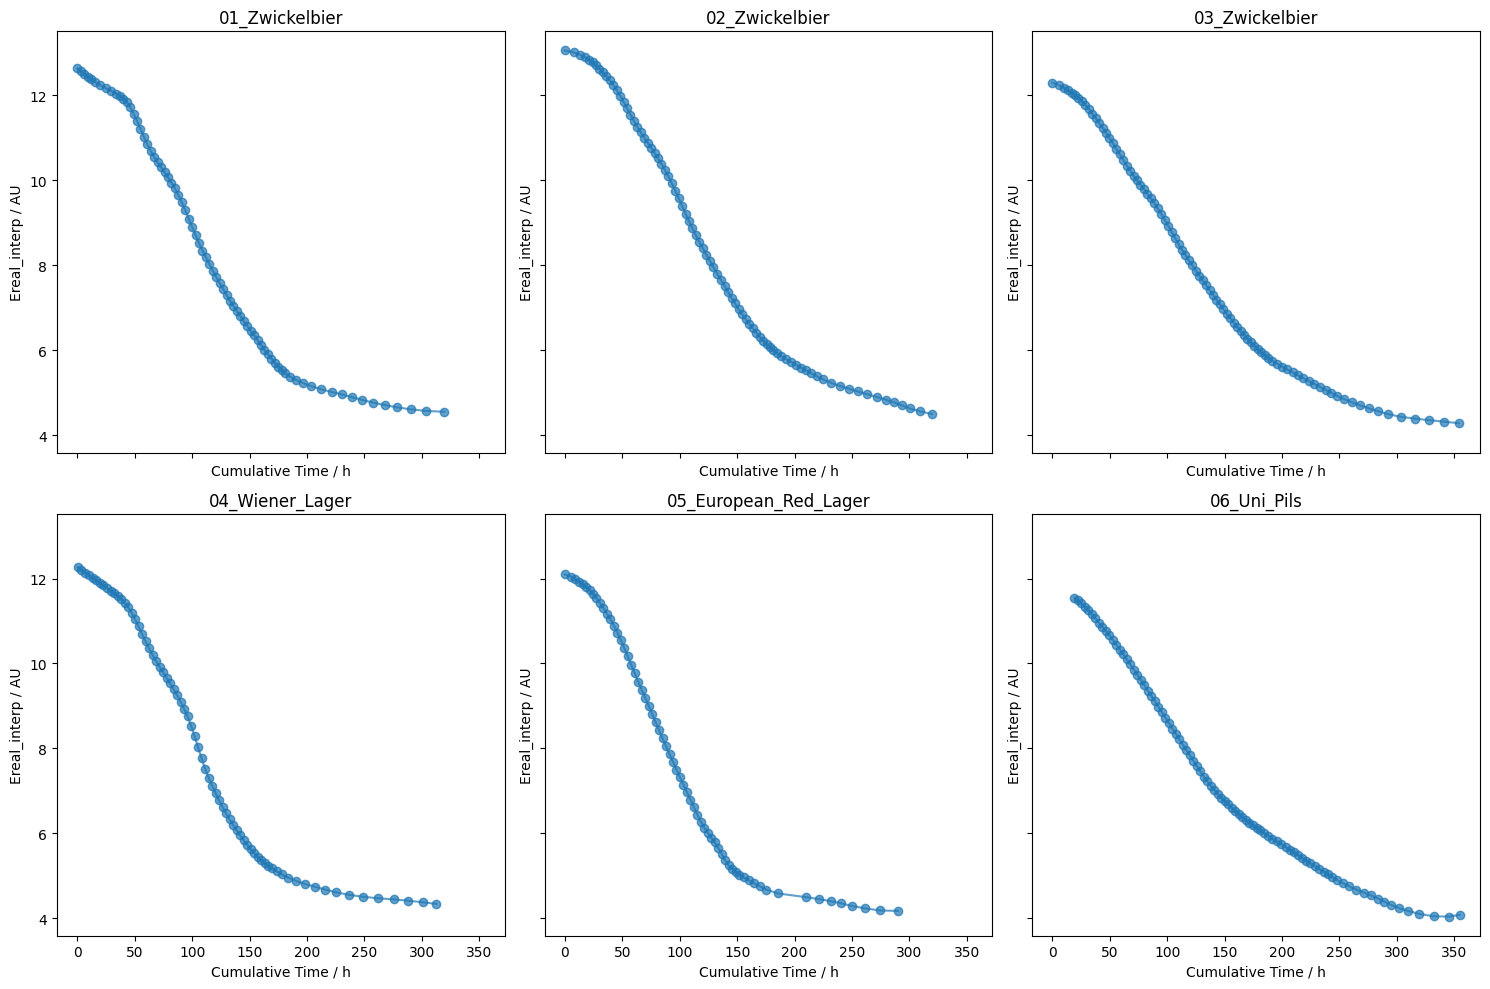

In [ ]:
# Plot Ereal_interp vs CumulativeTime for all batches in a grid of subplots
import matplotlib.pyplot as plt
batches = selected_df["BatchName"].unique().sort().to_list()
n_batches = len(batches)
n_cols = 3
n_rows = int(np.ceil(n_batches / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
for i, batch in enumerate(batches):
    ax = axes[i // n_cols, i % n_cols]
    batch_data = selected_df.filter(pl.col("BatchName") == batch)
    ax.plot(batch_data["CumulativeTime"], batch_data["Ereal_interp"], marker='o', linestyle='-', alpha=0.7)
    ax.set_title(batch)
    ax.set_xlabel("Cumulative Time / h")
    ax.set_ylabel("Ereal_interp / AU")
plt.tight_layout()
#plt.savefig("selected_points.jpg", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression

def calculate_vip_scores(pls_model):
    """
    Calculates VIP scores from a fitted scikit-learn PLS model.
    This version is corrected to avoid the NumPy deprecation warning.
    """
    if not hasattr(pls_model, 'x_scores_'):
        raise ValueError("The PLS model must be fitted before calculating VIP scores.")

    t = pls_model.x_scores_      # T scores (n_samples, n_components)
    w = pls_model.x_weights_     # W weights (n_features, n_components)
    q = pls_model.y_loadings_    # Q loadings (n_targets, n_components)

    p, h = w.shape  # p: number of features, h: number of components

    # Sum of squares of explained variance for each component
    ssy = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    ssy_total = np.sum(ssy)

    vips = np.zeros((p,))
    for i in range(p):
        # Weight of the i-th variable for each component
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        
        # Corrected calculation: Use np.dot on 1D arrays to ensure a scalar result
        vips[i] = np.sqrt(p * np.dot(ssy.flatten(), weight) / ssy_total)

    return vips

class VIPSelector(BaseEstimator, TransformerMixin):
    """
    A transformer that selects features based on VIP scores from an internal PLS model.
    The VIP threshold is a tunable hyperparameter.
    """
    def __init__(self, n_components_pls=10, vip_threshold=1.0):
        self.n_components_pls = n_components_pls
        self.vip_threshold = vip_threshold
        self.mask_ = None

    def fit(self, X, y):
        # Fit an internal PLS model to calculate VIP scores
        internal_pls = PLSRegression(n_components=self.n_components_pls)
        internal_pls.fit(X, y)

        # Calculate VIP scores and create the selection mask
        vip_scores = calculate_vip_scores(internal_pls)
        self.mask_ = vip_scores >= self.vip_threshold
        
        # Check if any features were selected
        if not np.any(self.mask_):
            print(f"Warning: No features selected with VIP threshold {self.vip_threshold}. Keeping all features.")
            self.mask_ = np.ones(X.shape[1], dtype=bool)

        return self

    def transform(self, X):
        return X[:, self.mask_]


===== FOLD 1/6: Holding out batch '01_Zwickelbier' =====

Starting GridSearchCV for fold 1... (Training on 387 samples)
Best parameters for this fold: {'regressor__emsc__order': np.int64(1), 'regressor__pls__n_components': np.int64(12), 'regressor__sg__polynomial_order': np.int64(2), 'regressor__sg__window_size': np.int64(12), 'regressor__vip__vip_threshold': np.float64(0.9)}
Best model for fold 1 without 01_Zwickelbier in the trainings set saved as 'best_model_fold_without_01_Zwickelbier.joblib'
MSE for Ereal (holdout 01_Zwickelbier): 0.1905
MSE for Ethanol (holdout 01_Zwickelbier): 0.0435
R² for Ereal (holdout 01_Zwickelbier): 0.9741
R² for Ethanol (holdout 01_Zwickelbier): 0.9780

===== FOLD 2/6: Holding out batch '02_Zwickelbier' =====

Starting GridSearchCV for fold 2... (Training on 381 samples)
Best parameters for this fold: {'regressor__emsc__order': np.int64(1), 'regressor__pls__n_components': np.int64(11), 'regressor__sg__polynomial_order': np.int64(2), 'regressor__sg__windo

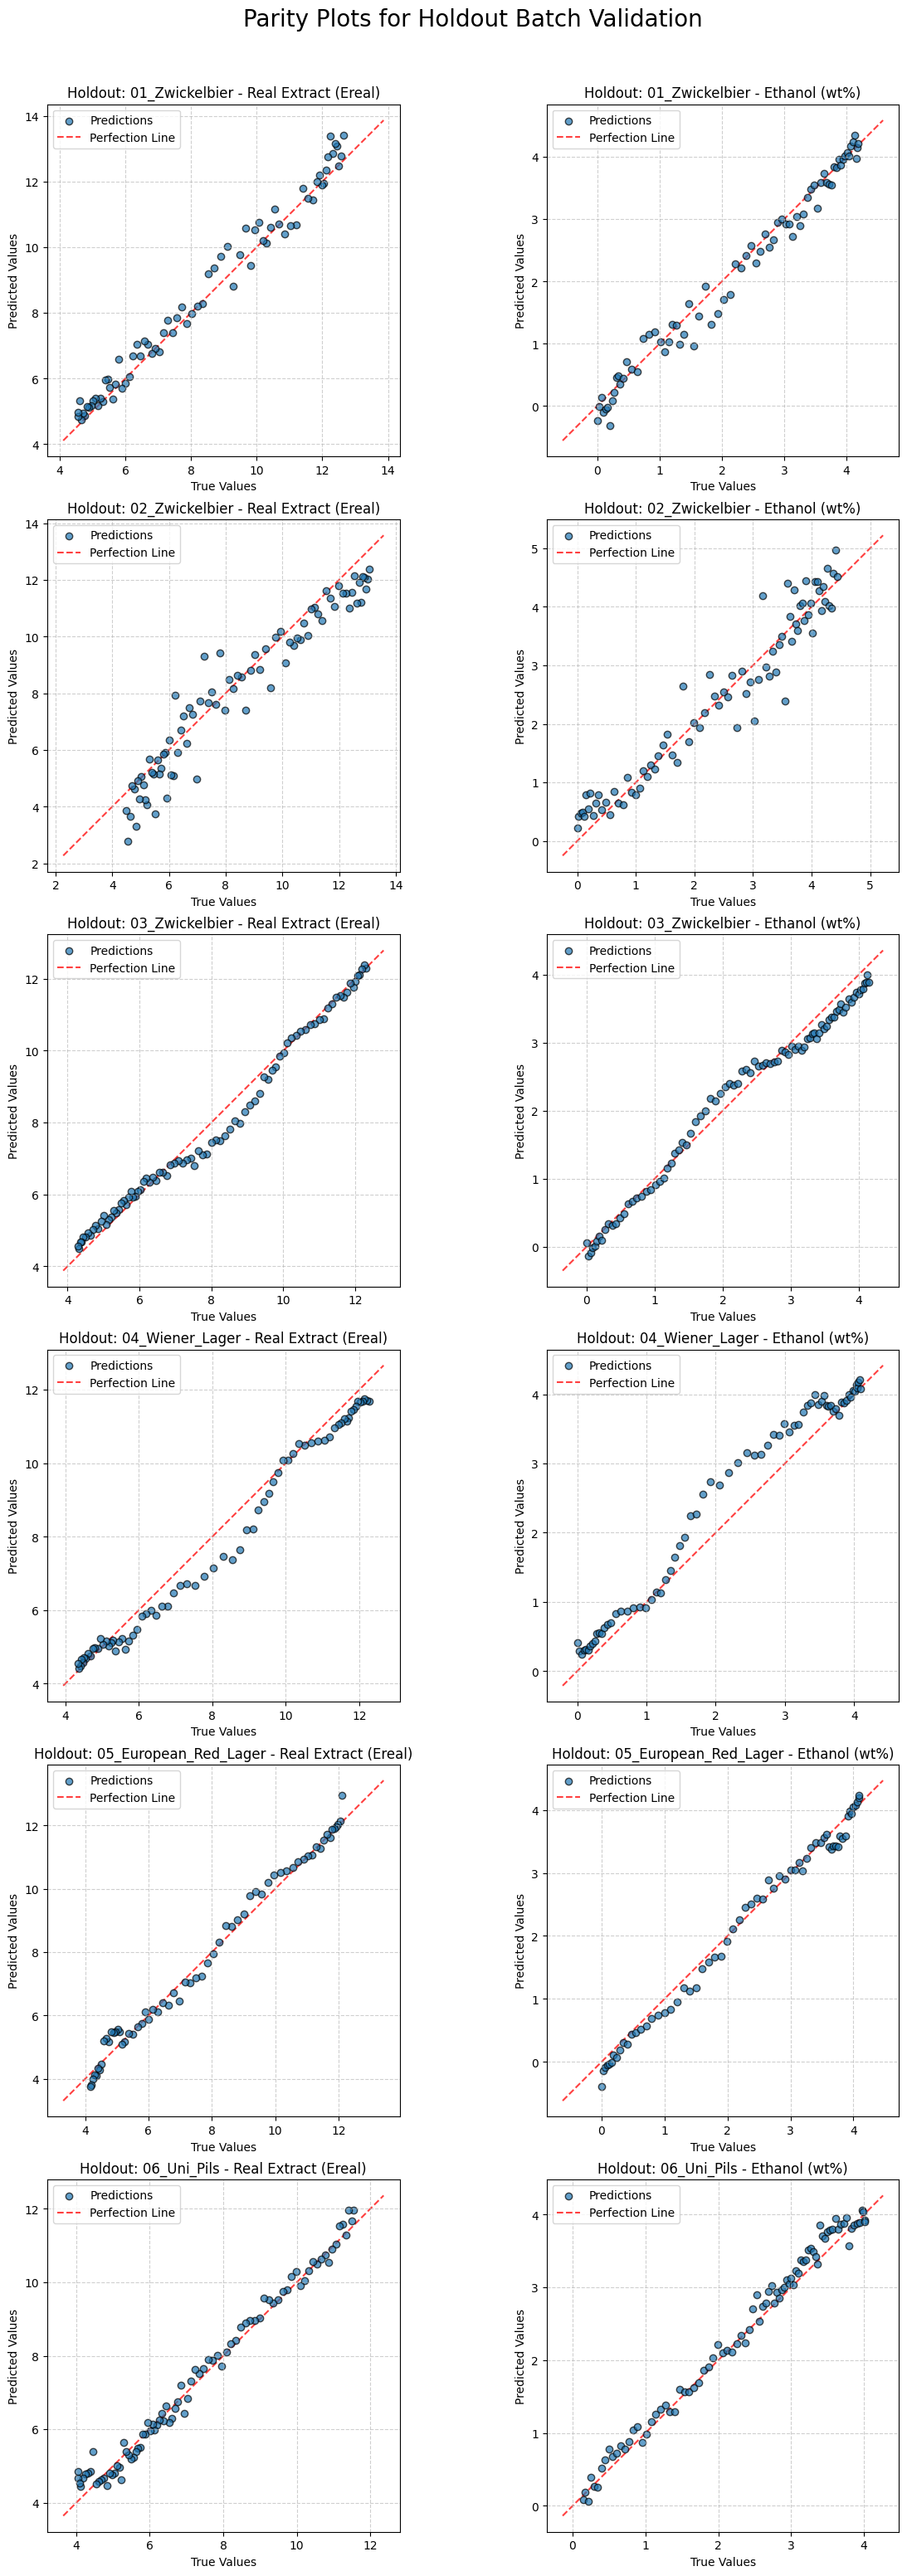

In [ ]:
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, cross_val_score,KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from chemotools.scatter import ExtendedMultiplicativeScatterCorrection
from chemotools.feature_selection import RangeCut
from chemotools.derivative import SavitzkyGolay
import joblib
from sklearn.compose import TransformedTargetRegressor

# --- Leave-One-Batch-Out Cross-Validation and Plotting ---
df = selected_df
#.filter(~pl.col("BatchName").is_in(["01_Zwickelbier", "02_Zwickelbier"]))


# Get all unique batch names to iterate over
all_batches = sorted(df["BatchName"].unique())
n_batches = len(all_batches)

# Create a subplot grid for all the parity plots
fig, axes = plt.subplots(n_batches, 2, figsize=(12, 5 * n_batches), constrained_layout=True)
fig.suptitle('Parity Plots for Holdout Batch Validation', fontsize=20, y=1.03)



# Loop through each batch, treating it as the holdout set once
for i, holdout_batch in enumerate(all_batches):
    print(f"\n===== FOLD {i+1}/{n_batches}: Holding out batch '{holdout_batch}' =====\n")


    df_train = df.filter(pl.col("BatchName") != holdout_batch)
    df_holdout = df.filter(pl.col("BatchName") == holdout_batch)

    X_train = df_train.select(pl.col("^WL.*$")).to_numpy()
    y_train = df_train.select(["Ereal_interp", "wtPercEtOH_interp"]).to_numpy()
    groups = df_train["BatchName"].to_numpy()

    X_holdout = df_holdout.select(pl.col("^WL.*$")).to_numpy()
    y_true_holdout = df_holdout.select(["Ereal_interp", "wtPercEtOH_interp"]).to_numpy()

   
    pipeline = Pipeline([
        ('rangecut', RangeCut(30, -30)),
        ('emsc', ExtendedMultiplicativeScatterCorrection()),
        ('sg', SavitzkyGolay(derivate_order=1)),
        ('scaler', StandardScaler()),
        ('vip', VIPSelector(n_components_pls=6)),
        ('pls', PLSRegression(scale=False))
    ])

    model_with_y_scaling = TransformedTargetRegressor(
        regressor=pipeline,
        transformer=StandardScaler()
    )

    param_grid = {
        'regressor__pls__n_components': np.arange(6, 16),  # Example range of components to try
        'regressor__vip__vip_threshold': np.arange(0.8, 1.2, 0.1),  # Example thresholds to try
        'regressor__emsc__order': np.arange(1, 4),  # Example orders to try
        'regressor__sg__window_size': np.arange(11, 20, 1),  # Example window sizes to try
        'regressor__sg__polynomial_order': np.arange(2, 5, 1),
    }

    print(f"Starting GridSearchCV for fold {i+1}... (Training on {len(df_train)} samples)")
    logo = LeaveOneGroupOut()
    grid_search = GridSearchCV(
        model_with_y_scaling,
        param_grid,
        cv=logo,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train, groups=groups)

    best_model = grid_search.best_estimator_
    
    print("Best parameters for this fold:", grid_search.best_params_)

    joblib.dump(best_model, f'models/best_model_without_{holdout_batch}.joblib')
    print(f"Best model for fold {i+1} without {holdout_batch} in the trainings set saved as 'best_model_fold_without_{holdout_batch}.joblib'")

    y_pred_holdout = best_model.predict(X_holdout)

    # Calculate and print MSE for both targets
    mse_ereal = np.mean((y_true_holdout[:, 0] - y_pred_holdout[:, 0]) ** 2)
    mse_ethanol = np.mean((y_true_holdout[:, 1] - y_pred_holdout[:, 1]) ** 2)
    print(f"MSE for Ereal (holdout {holdout_batch}): {mse_ereal:.4f}")
    print(f"MSE for Ethanol (holdout {holdout_batch}): {mse_ethanol:.4f}")

    # Calculate R2 for both targets
    from sklearn.metrics import r2_score
    r2_ereal = r2_score(y_true_holdout[:, 0], y_pred_holdout[:, 0])
    r2_ethanol = r2_score(y_true_holdout[:, 1], y_pred_holdout[:, 1])
    print(f"R² for Ereal (holdout {holdout_batch}): {r2_ereal:.4f}")
    print(f"R² for Ethanol (holdout {holdout_batch}): {r2_ethanol:.4f}")

    targets = ['Real Extract (Ereal)', 'Ethanol (wt%)']
    for j in range(2): # Loop for each target variable
        ax = axes[i, j]
        true_vals = y_true_holdout[:, j]
        pred_vals = y_pred_holdout[:, j]

        ax.scatter(true_vals, pred_vals, alpha=0.7, edgecolors='k', label='Predictions')
        
        lims = [
            np.min([true_vals, pred_vals]),
            np.max([true_vals, pred_vals])
        ]
        padding = (lims[1] - lims[0]) * 0.05
        lims = [lims[0] - padding, lims[1] + padding]
        
        ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfection Line')
        
        ax.set_title(f"Holdout: {holdout_batch} - {targets[j]}", fontsize=12)
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        ax.set_aspect('equal', adjustable='box')

plt.show()


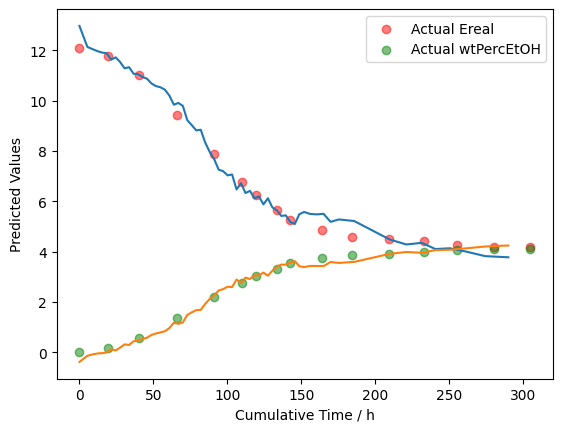

In [524]:
import matplotlib.pyplot as plt

# Import the best model from the previous cell joblib dump
import joblib
holdout_batch = "05_European_Red_Lager"  # Change this to visualize different batches
best_model = joblib.load(f'models/best_model_without_{holdout_batch}.joblib')

X_holdout =selected_df.filter(pl.col("BatchName") == holdout_batch).select(pl.col("^WL.*$")).to_numpy()

predicted_values = best_model.predict(X_holdout)

plt.plot(selected_df.filter(pl.col("BatchName") == holdout_batch)["CumulativeTime"], predicted_values)
# Add the df_dsa values for comparison
plt.scatter(df_dsa.filter(pl.col("BatchName") == holdout_batch)["CumulativeTime"], df_dsa.filter(pl.col("BatchName") == holdout_batch)["Ereal"], color='red', label='Actual Ereal', alpha=0.5)
plt.scatter(df_dsa.filter(pl.col("BatchName") == holdout_batch)["CumulativeTime"], df_dsa.filter(pl.col("BatchName") == holdout_batch)["wtPercEtOH"], color='green', label='Actual wtPercEtOH', alpha=0.5)
plt.xlabel("Cumulative Time / h")
plt.ylabel("Predicted Values")
plt.legend()



===== FOLD 1/6: Holding out batch '01_Zwickelbier' =====

Starting GridSearchCV for fold 1... (Training on 387 samples)
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters for this fold: {'regressor__emsc__order': np.int64(1), 'regressor__mlp__alpha': 10, 'regressor__mlp__hidden_layer_sizes': (40,), 'regressor__sg__polynomial_order': np.int64(4), 'regressor__sg__window_size': np.int64(13)}
Best model for fold 1 saved as 'models/best_model_shallow_mlp_without_01_Zwickelbier.joblib'
MSE for Ereal (holdout 01_Zwickelbier): 0.2835
MSE for Ethanol (holdout 01_Zwickelbier): 0.0723
R² for Ereal (holdout 01_Zwickelbier): 0.9615
R² for Ethanol (holdout 01_Zwickelbier): 0.9634

===== FOLD 2/6: Holding out batch '02_Zwickelbier' =====

Starting GridSearchCV for fold 2... (Training on 381 samples)
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters for this fold: {'regressor__emsc__order': np.int64(3), 'regressor__mlp__alpha': 10, 'regressor

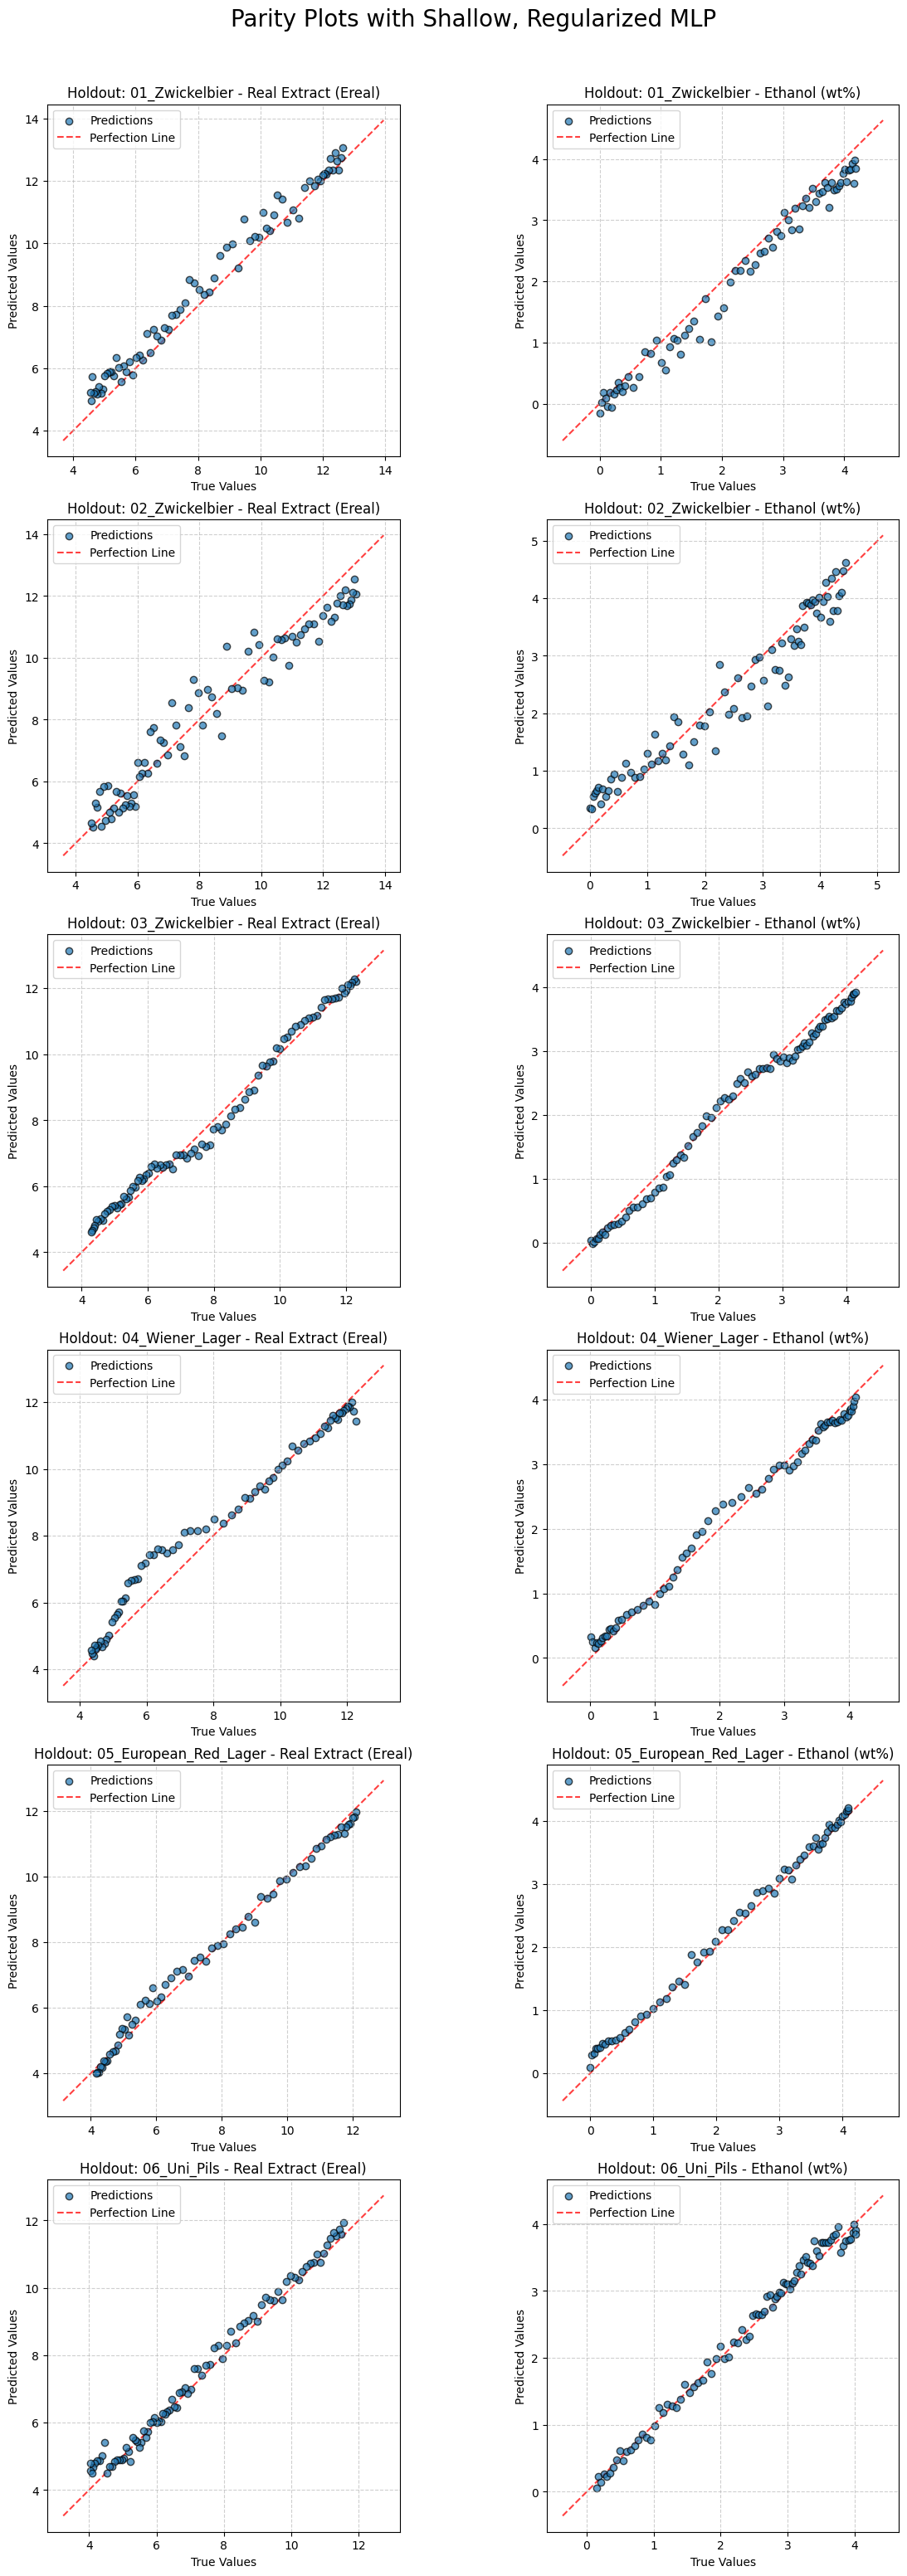

In [520]:
from sklearn.neural_network import MLPRegressor
import os

# --- Leave-One-Batch-Out Cross-Validation and Plotting ---
df = selected_df

# Get all unique batch names to iterate over
all_batches = sorted(df["BatchName"].unique().to_list())
n_batches = len(all_batches)

# Create a subplot grid for all the parity plots
fig, axes = plt.subplots(n_batches, 2, figsize=(12, 5 * n_batches), constrained_layout=True)
fig.suptitle('Parity Plots with Shallow, Regularized MLP', fontsize=20, y=1.03)


# Loop through each batch, treating it as the holdout set once
for i, holdout_batch in enumerate(all_batches):
    print(f"\n===== FOLD {i+1}/{n_batches}: Holding out batch '{holdout_batch}' =====\n")

    df_train = df.filter(pl.col("BatchName") != holdout_batch)
    df_holdout = df.filter(pl.col("BatchName") == holdout_batch)

    X_train = df_train.select(pl.col("^WL.*$")).to_numpy()
    y_train = df_train.select(["Ereal_interp", "wtPercEtOH_interp"]).to_numpy()
    groups = df_train["BatchName"].to_numpy()

    X_holdout = df_holdout.select(pl.col("^WL.*$")).to_numpy()
    y_true_holdout = df_holdout.select(["Ereal_interp", "wtPercEtOH_interp"]).to_numpy()

    
    pipeline = Pipeline([
        ('rangecut', RangeCut(30, -30)),
        ('emsc', ExtendedMultiplicativeScatterCorrection()),
        ('sg', SavitzkyGolay(derivate_order=1)),
        ('scaler', StandardScaler()),
        # Using a high max_iter and early_stopping is good practice for convergence
        ('mlp', MLPRegressor(activation='tanh', random_state=42, max_iter=1500, early_stopping=True, n_iter_no_change=15))
    ])

    model_with_y_scaling = TransformedTargetRegressor(
        regressor=pipeline,
        transformer=StandardScaler()
    )

    # --- MODIFICATION: Grid for a shallow, strongly regularized MLP ---
    param_grid = {
        # Using a single hidden layer with few neurons to create a "shallow" network
        'regressor__mlp__hidden_layer_sizes': [(20,), (30,), (40,)],  # Single hidden layer with 20, 30, or 40 neurons

        # Using larger alpha values for stronger L2 regularization to prevent overfitting
        'regressor__mlp__alpha': [0.1, 1, 10],
        
        #'regressor__mlp__activation': ['tanh'],

        # Reduced the search space for preprocessing to speed up the grid search
        'regressor__emsc__order': np.arange(1, 4),  # Example orders to try
        'regressor__sg__window_size': np.arange(11, 20, 1),  # Example window sizes to try
        'regressor__sg__polynomial_order': np.arange(2, 5, 1),
    }

    print(f"Starting GridSearchCV for fold {i+1}... (Training on {len(df_train)} samples)")
    logo = LeaveOneGroupOut()
    grid_search = GridSearchCV(
        model_with_y_scaling,
        param_grid,
        cv=logo,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1 
    )
    grid_search.fit(X_train, y_train, groups=groups)

    best_model = grid_search.best_estimator_
    
    print("Best parameters for this fold:", grid_search.best_params_)

    os.makedirs('models', exist_ok=True)
    joblib.dump(best_model, f'models/best_model_shallow_mlp_without_{holdout_batch}.joblib')
    print(f"Best model for fold {i+1} saved as 'models/best_model_shallow_mlp_without_{holdout_batch}.joblib'")

    y_pred_holdout = best_model.predict(X_holdout)

    # Calculate and print MSE for both targets
    mse_ereal = np.mean((y_true_holdout[:, 0] - y_pred_holdout[:, 0]) ** 2)
    mse_ethanol = np.mean((y_true_holdout[:, 1] - y_pred_holdout[:, 1]) ** 2)
    print(f"MSE for Ereal (holdout {holdout_batch}): {mse_ereal:.4f}")
    print(f"MSE for Ethanol (holdout {holdout_batch}): {mse_ethanol:.4f}")

    # Calculate R2 for both targets
    r2_ereal = r2_score(y_true_holdout[:, 0], y_pred_holdout[:, 0])
    r2_ethanol = r2_score(y_true_holdout[:, 1], y_pred_holdout[:, 1])
    print(f"R² for Ereal (holdout {holdout_batch}): {r2_ereal:.4f}")
    print(f"R² for Ethanol (holdout {holdout_batch}): {r2_ethanol:.4f}")

    targets = ['Real Extract (Ereal)', 'Ethanol (wt%)']
    for j in range(2):
        ax = axes[i, j]
        true_vals = y_true_holdout[:, j]
        pred_vals = y_pred_holdout[:, j]

        ax.scatter(true_vals, pred_vals, alpha=0.7, edgecolors='k', label='Predictions')
        
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])
        ]
        padding = (lims[1] - lims[0]) * 0.05
        lims = [lims[0] - padding, lims[1] + padding]
        
        ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfection Line')
        
        ax.set_title(f"Holdout: {holdout_batch} - {targets[j]}", fontsize=12)
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        ax.set_aspect('equal', adjustable='box')

plt.show()

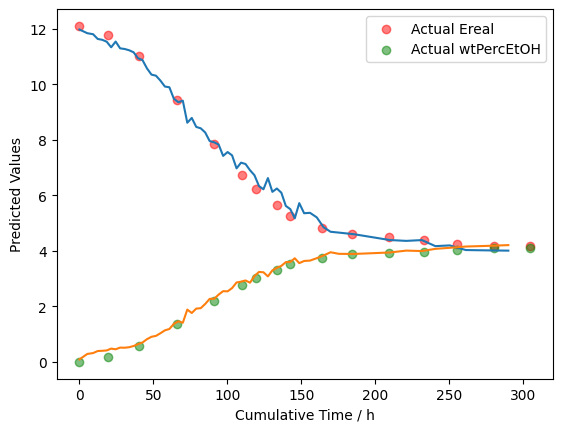

In [525]:
import matplotlib.pyplot as plt

# Import the best model from the previous cell joblib dump
import joblib
holdout_batch = "05_European_Red_Lager"  # Change this to visualize different batches
best_model = joblib.load(f'models/best_model_shallow_mlp_without_{holdout_batch}.joblib')

X_holdout = selected_df.filter(pl.col("BatchName") == holdout_batch).select(pl.col("^WL.*$")).to_numpy()

predicted_values = best_model.predict(X_holdout)

plt.plot(selected_df.filter(pl.col("BatchName") == holdout_batch)["CumulativeTime"], predicted_values)
# Add the df_dsa values for comparison
plt.scatter(df_dsa.filter(pl.col("BatchName") == holdout_batch)["CumulativeTime"], df_dsa.filter(pl.col("BatchName") == holdout_batch)["Ereal"], color='red', label='Actual Ereal', alpha=0.5)
plt.scatter(df_dsa.filter(pl.col("BatchName") == holdout_batch)["CumulativeTime"], df_dsa.filter(pl.col("BatchName") == holdout_batch)["wtPercEtOH"], color='green', label='Actual wtPercEtOH', alpha=0.5)
plt.xlabel("Cumulative Time / h")
plt.ylabel("Predicted Values")
plt.legend()